## Loading the libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, auc, roc_curve
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm, model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process


In [2]:
## Loading the datasets

train_original = pd.read_csv('train.csv')
test_original = pd.read_csv('test.csv')
train_original.sample(10)
total = [train_original, test_original]

## Data Cleaning 

In [3]:
## Retrive the salutation from 'Name' column
for dataset in total:
    dataset['Salutation'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [4]:
pd.crosstab(train_original['Salutation'], train_original['Sex'])

Sex,female,male
Salutation,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [5]:
pd.crosstab(test_original['Salutation'], test_original['Sex'])

Sex,female,male
Salutation,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [6]:
for dataset in total:
    dataset['Salutation'] = dataset['Salutation'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Salutation'] = dataset['Salutation'].replace('Mlle','Miss')
    dataset['Salutation'] = dataset['Salutation'].replace('Ms','Miss')
    dataset['Salutation'] = dataset['Salutation'].replace('Mm','Mrs')
    dataset['Salutation'] = pd.factorize(dataset['Salutation'])[0]

In [7]:
pd.crosstab(train_original['Salutation'], train_original['Sex'])

Sex,female,male
Salutation,,
0,0,517
1,125,0
2,185,0
3,0,40
4,3,20
5,1,0


In [8]:
pd.crosstab(test_original['Salutation'], test_original['Sex'])

Sex,female,male
Salutation,,
0,0,240
1,72,0
2,79,0
3,0,21
4,1,5


In [9]:
## Dropping unused variables

train = train_original.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
test = test_original.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)

total = [train,test]

train.shape, test.shape

((891, 9), (418, 8))

In [10]:
## Treating missing values 

train.isnull().mean()

Survived      0.000000
Pclass        0.000000
Sex           0.000000
Age           0.198653
SibSp         0.000000
Parch         0.000000
Fare          0.000000
Embarked      0.002245
Salutation    0.000000
dtype: float64

In [11]:
## Imputing missing with median

def fill_missing_age(dataset):
    for i in range(1,4):
        median_age = dataset[dataset['Salutation']==i]['Age'].median()
        dataset['Age'] = dataset['Age'].fillna(median_age)
        return dataset

train = fill_missing_age(train)

In [12]:
## Embarked missing values 

train[train['Embarked'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Salutation
61,1,1,female,38.0,0,0,80.0,NaN,2
829,1,1,female,62.0,0,0,80.0,NaN,1


In [13]:
train['Embarked'] = train['Embarked'].fillna('C')

In [14]:
## missing values in test

test.isnull().mean()

Pclass        0.000000
Sex           0.000000
Age           0.205742
SibSp         0.000000
Parch         0.000000
Fare          0.002392
Embarked      0.000000
Salutation    0.000000
dtype: float64

In [15]:
test[test['Age'].isnull()].head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Salutation
10,3,male,NaN,0,0,7.8958,S,0
22,1,female,NaN,0,0,31.6833,S,1
29,3,male,NaN,2,0,21.6792,C,0
33,3,female,NaN,1,2,23.4500,S,1
36,3,female,NaN,0,0,8.0500,S,2


In [16]:
test = fill_missing_age(test)

In [17]:
test[test['Fare'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Salutation
152,3,male,60.5,0,0,NaN,S,0


In [18]:
def fill_missing_fare(dataset):
    median_fare = dataset[(dataset['Pclass']==3)&(dataset['Embarked']=='S')]['Fare'].median()
    dataset['Fare'] = dataset['Fare'].fillna(median_fare)
    return dataset

test = fill_missing_fare(test)

In [19]:
train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Salutation    0
dtype: int64

In [20]:
test.isnull().any()

Pclass        False
Sex           False
Age           False
SibSp         False
Parch         False
Fare          False
Embarked      False
Salutation    False
dtype: bool

In [21]:
## Discretize age

for dataset in total:
    dataset.loc[dataset['Age']<=9, 'Age'] = 0
    dataset.loc[(dataset['Age']>9) & (dataset['Age']<=19), 'Age'] = 1
    dataset.loc[(dataset['Age']>19) & (dataset['Age']<=29), 'Age'] = 2
    dataset.loc[(dataset['Age']>29) & (dataset['Age']<=39), 'Age'] = 3
    dataset.loc[dataset['Age']>39, 'Age'] = 4

In [22]:
## Discretize Fare

pd.qcut(train['Fare'], 8).value_counts()

(-0.001, 7.75]       140
(9.841, 14.454]      113
(24.479, 31.0]       112
(69.488, 512.329]    112
(7.91, 9.841]        111
(14.454, 24.479]     110
(31.0, 69.488]       110
(7.75, 7.91]          83
Name: Fare, dtype: int64

In [23]:
for dataset in total:
    dataset.loc[dataset['Fare'] <= 7.75, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.75) & (dataset['Fare'] <= 7.91), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 9.841), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 9.841) & (dataset['Fare'] <= 14.454), 'Fare'] = 3
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 24.479), 'Fare'] = 4
    dataset.loc[(dataset['Fare'] > 24.479) & (dataset['Fare'] <= 31), 'Fare'] = 5
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 69.487), 'Fare'] = 6
    dataset.loc[dataset['Fare'] > 69.487, 'Fare'] = 7

In [24]:
## Factorizing column 'Sex' and 'Embarked'

for dataset in total:
    dataset['Sex'] = pd.factorize(dataset['Sex'])[0]
    dataset['Embarked'] = pd.factorize(dataset['Embarked'])[0]
    
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Salutation
0,0,3,0,2.0,1,0,0.0,0,0
1,1,1,1,3.0,1,0,7.0,1,1
2,1,3,1,2.0,0,0,2.0,0,2
3,1,1,1,3.0,1,0,6.0,0,1
4,0,3,0,3.0,0,0,2.0,0,0


<AxesSubplot:>

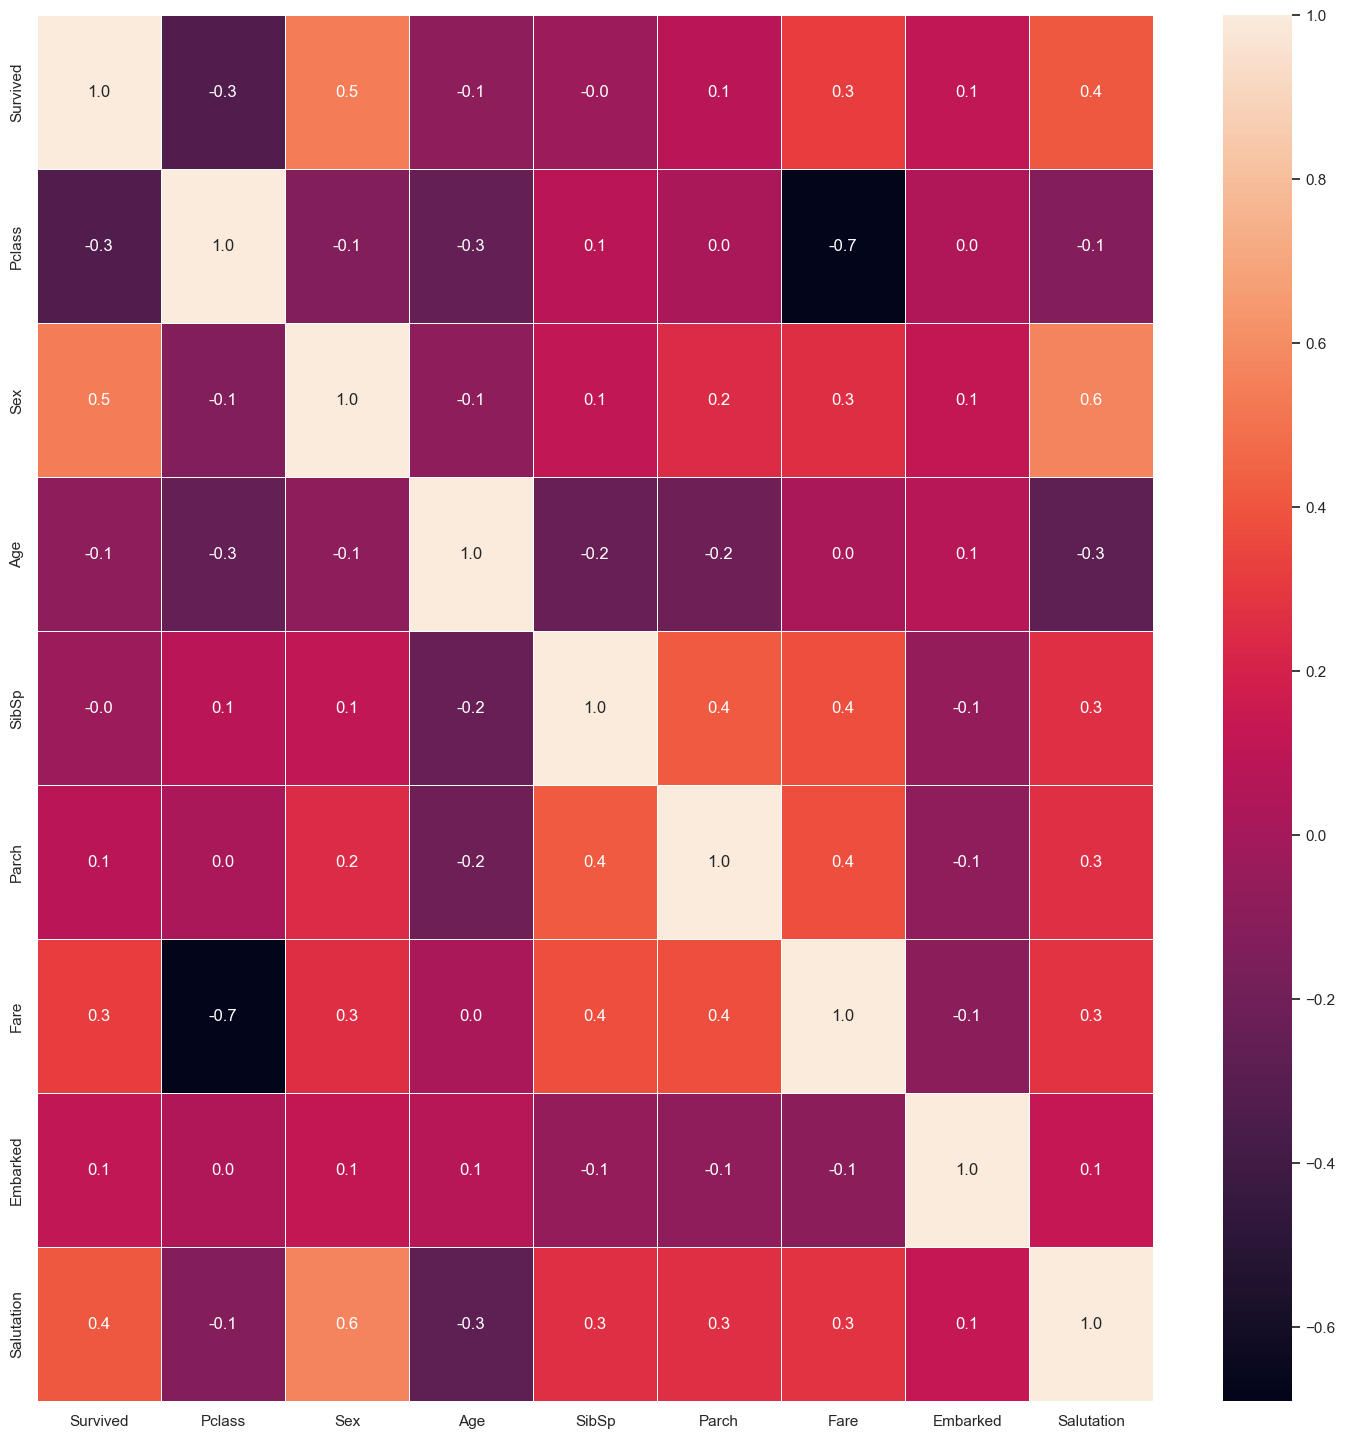

In [25]:
## Checking the correlation between features

f, ax = plt.subplots(figsize=(18,18))
sns.heatmap(train.corr(), annot=True, linewidths=0.5, fmt= '.1f', ax=ax)

### Spliting the data

In [26]:
x = train.drop('Survived', axis=1)
y = train['Survived']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=1)

## Performance Comparison

In [28]:
MLA = [
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    # Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    # GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    # Naives Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    # Nearest Neighbors
    neighbors.KNeighborsClassifier(),
    
    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    # Trees
    tree.DecisionTreeClassifier()
]

In [29]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns=MLA_columns)

row_index = 0
for alg in MLA:
    
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Train Accuracy'] = round(alg.score(X_train, y_train), 4)
    MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(alg.score(X_test, y_test), 4)
    MLA_compare.loc[row_index, 'MLA Precision'] = precision_score(y_test, predicted)
    MLA_compare.loc[row_index, 'MLA Recall'] = recall_score(y_test, predicted)
    MLA_compare.loc[row_index, 'MLA AUC'] = auc(fp, tp)
    
    row_index += 1
    
    
MLA_compare.sort_values(by= ['MLA Test Accuracy'], ascending=False, inplace=True)
MLA_compare

,MLA Name,MLA Train Accuracy,MLA Test Accuracy,MLA Precision,MLA Recall,MLA AUC
1,BaggingClassifier,0.9057,0.7982,0.878788,0.610526,0.774013
16,LinearSVC,0.8054,0.7937,0.802469,0.684211,0.779605
6,LogisticRegressionCV,0.8129,0.7937,0.810127,0.673684,0.778248
15,NuSVC,0.8353,0.7937,0.818182,0.663158,0.776891
14,SVC,0.8428,0.7937,0.818182,0.663158,0.776891
2,ExtraTreesClassifier,0.9162,0.7892,0.833333,0.631579,0.768914
8,RidgeClassifierCV,0.8039,0.7892,0.785714,0.694737,0.777056
0,AdaBoostClassifier,0.8383,0.7848,0.813333,0.642105,0.766365
4,RandomForestClassifier,0.9162,0.7848,0.821918,0.631579,0.765008
12,GaussianNB,0.8129,0.7803,0.761364,0.705263,0.770600


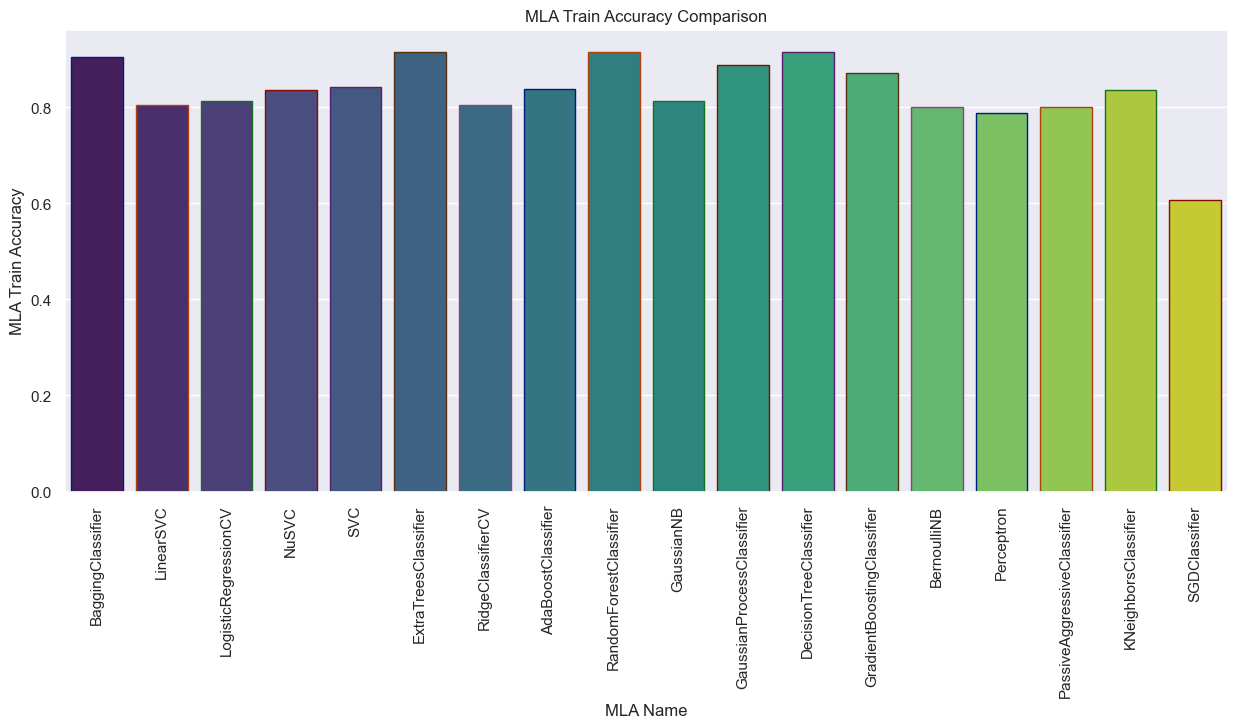

In [30]:
plt.subplots(figsize=(15,6))
sns.barplot(x='MLA Name', y='MLA Train Accuracy', data=MLA_compare, palette='viridis', edgecolor=sns.color_palette('dark', 7))
plt.xticks(rotation=90)
plt.title('MLA Train Accuracy Comparison')
plt.show()

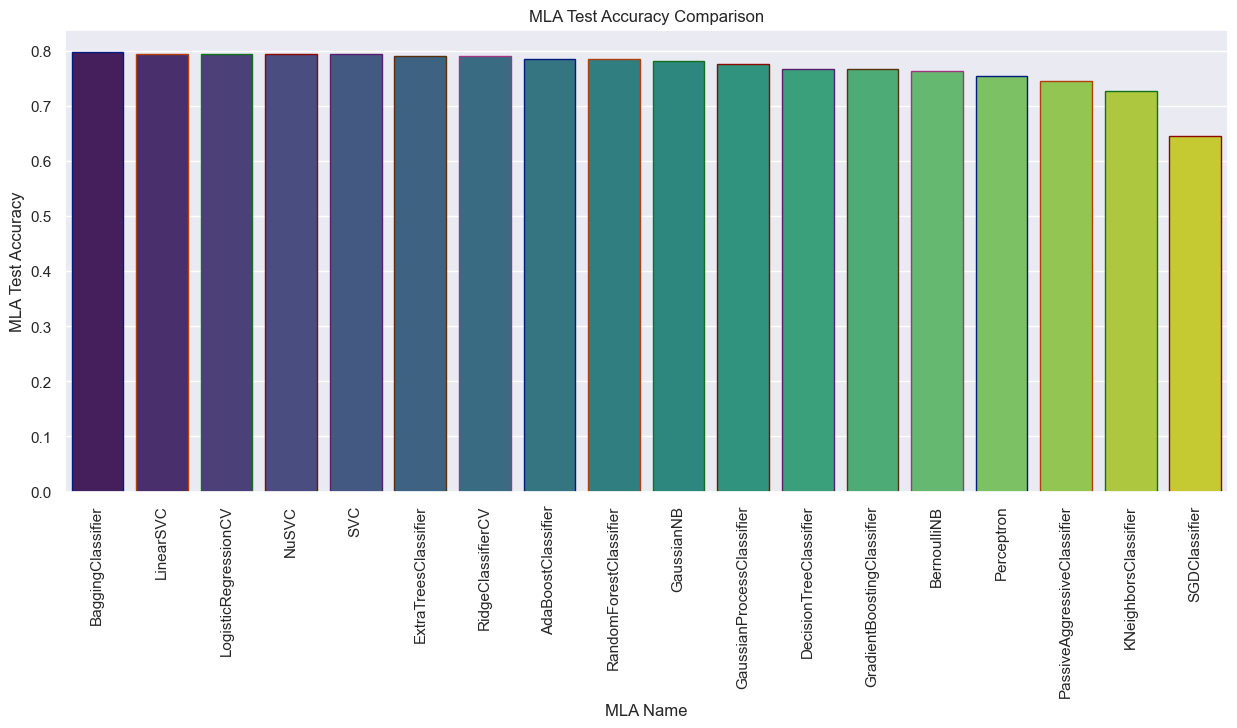

In [31]:
plt.subplots(figsize=(15,6))
sns.barplot(x='MLA Name', y='MLA Test Accuracy', data=MLA_compare, palette='viridis', edgecolor=sns.color_palette('dark', 7))
plt.xticks(rotation=90)
plt.title('MLA Test Accuracy Comparison')
plt.show()

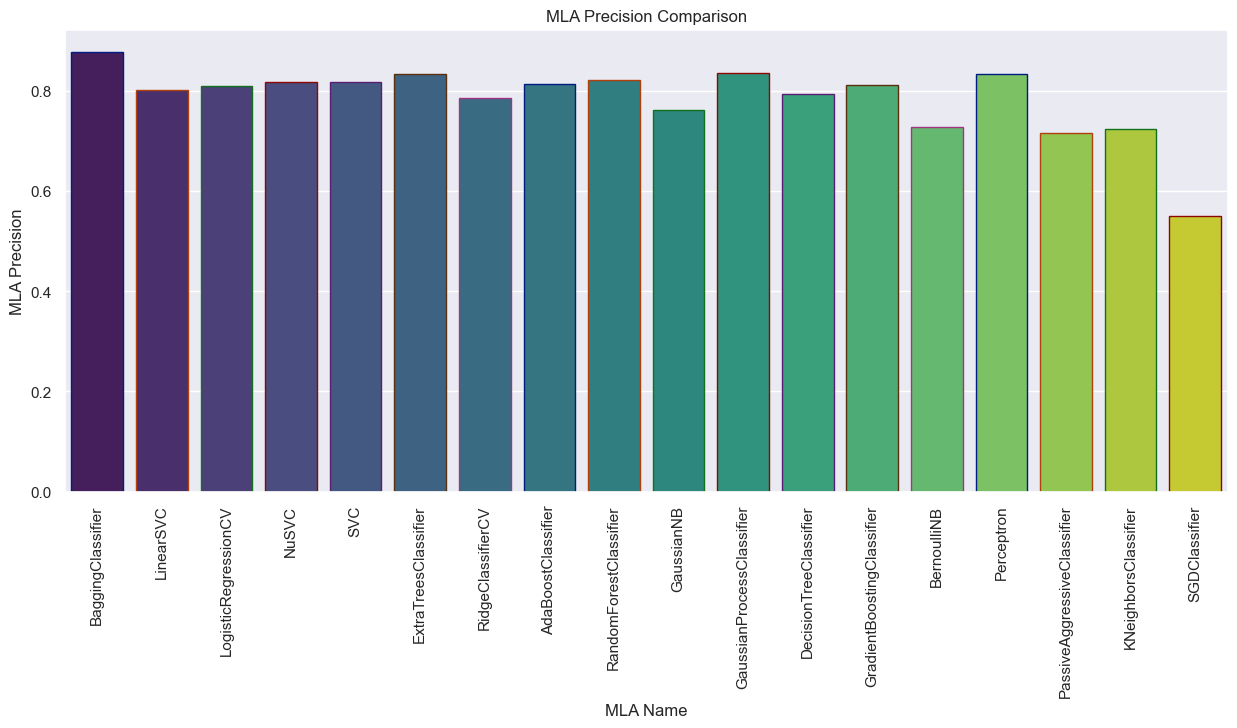

In [32]:
plt.subplots(figsize=(15,6))
sns.barplot(x='MLA Name', y='MLA Precision', data=MLA_compare, palette='viridis', edgecolor=sns.color_palette('dark', 7))
plt.xticks(rotation=90)
plt.title('MLA Precision Comparison')
plt.show()

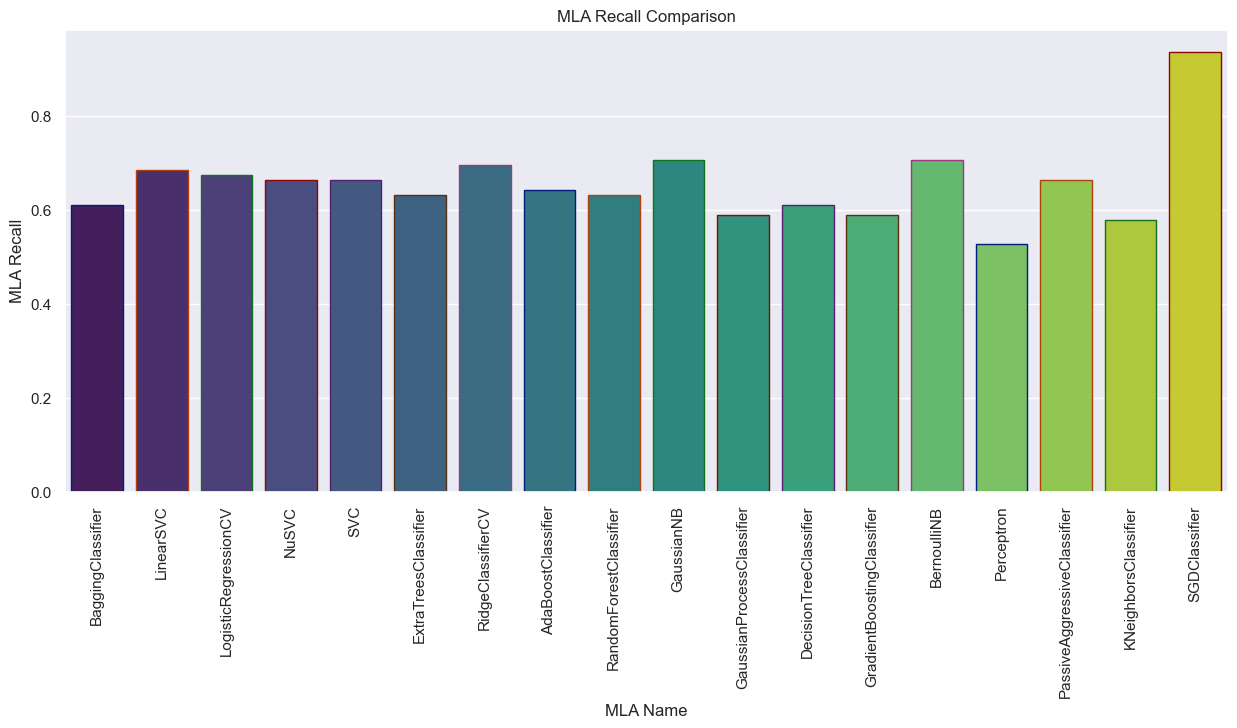

In [33]:
plt.subplots(figsize=(15,6))
sns.barplot(x='MLA Name', y='MLA Recall', data=MLA_compare, palette='viridis', edgecolor=sns.color_palette('dark', 7))
plt.xticks(rotation=90)
plt.title('MLA Recall Comparison')
plt.show()

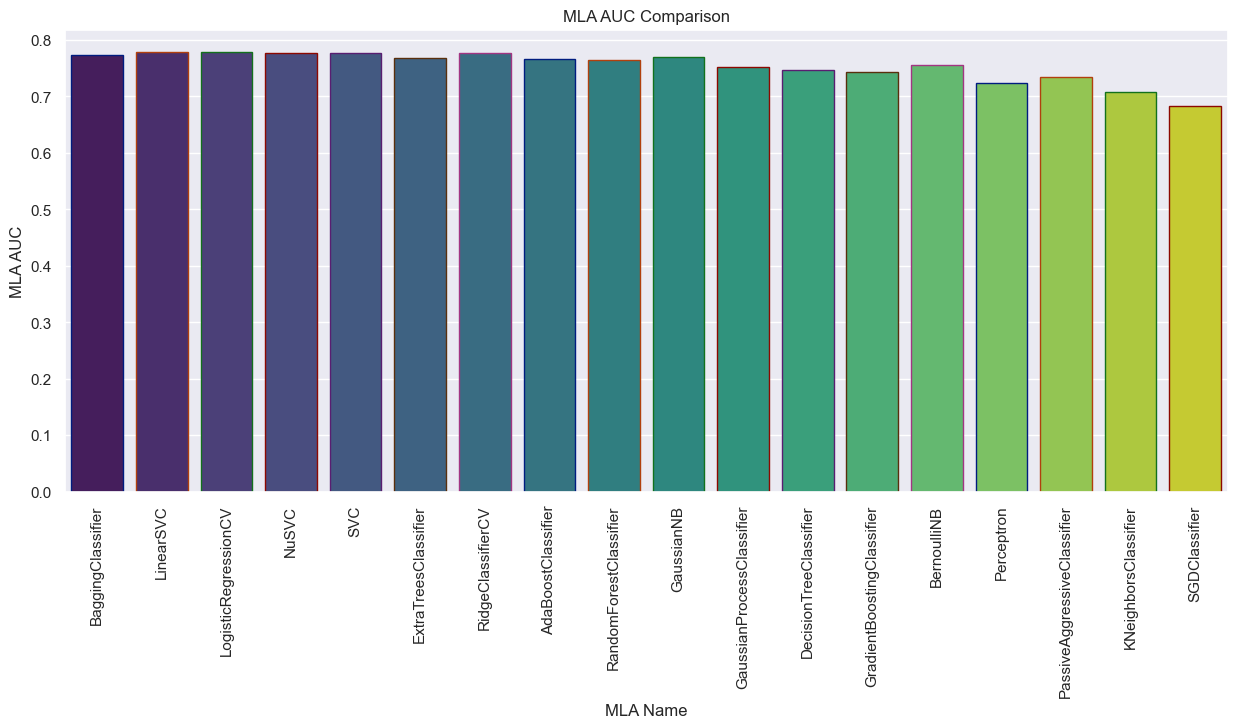

In [34]:
plt.subplots(figsize=(15,6))
sns.barplot(x='MLA Name', y='MLA AUC', data=MLA_compare, palette='viridis', edgecolor=sns.color_palette('dark', 7))
plt.xticks(rotation=90)
plt.title('MLA AUC Comparison')
plt.show()

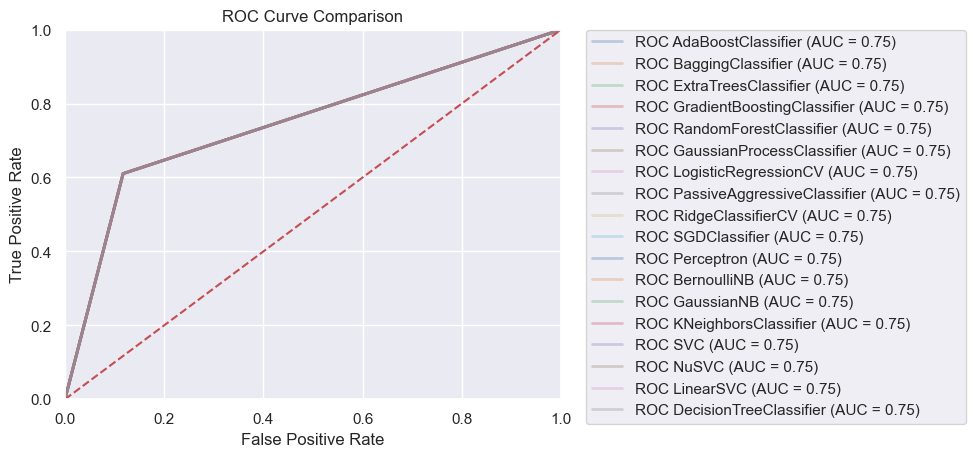

In [35]:
row_index = 0
for alg in MLA:
    
    
    Predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    MLA_name = alg.__class__.__name__
    roc_auc_mla = auc(fp, tp)
    plt.plot(fp, tp, lw=2, alpha=0.3, label='ROC %s (AUC = %0.2f)' % (MLA_name, roc_auc_mla))
    
    row_index += 1
    
plt.title('ROC Curve Comparison')
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Tuning the algorithm

In [36]:
tunealg = ensemble.ExtraTreesClassifier()
tunealg.fit(X_train, y_train)

print('Before tuning Parameters: ', tunealg.get_params())
print('Before tuning Training w/bin set score: {:.2f}'.format(tunealg.score(X_train, y_train)))
print('Before tuning Test w/bin set score: {:.2f}'.format(tunealg.score(X_test, y_test)))
print('-'*50)

Before tuning Parameters:  {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Before tuning Training w/bin set score: 0.92
Before tuning Test w/bin set score: 0.78
--------------------------------------------------


In [37]:
## Tune Parameters
param_grid = {'class_weight':['balanced', None],
             'n_jobs':[1,2,3,4,5],
             'random_state':[0,1,2,3,4, None],
             'warm_start':[True, False]
             }

tune_model = model_selection.GridSearchCV(linear_model.PassiveAggressiveClassifier(), param_grid=param_grid, scoring='roc_auc')
tune_model.fit(X_train, y_train)

print('After tuning Parameters: ', tune_model.best_params_)
print('After tuning Training w/bin set score: {:.2f}'.format(tune_model.score(X_train, y_train)))
print('After tuning Testing w/bin set score: {:.2f}'.format(tune_model.score(X_test, y_test)))
print('-'*50)

After tuning Parameters:  {'class_weight': None, 'n_jobs': 2, 'random_state': None, 'warm_start': True}
After tuning Training w/bin set score: 0.81
After tuning Testing w/bin set score: 0.77
--------------------------------------------------


# END